In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
import matplotlib
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Concatenate, Flatten, MaxPooling1D
from keras.models import Model
from itertools import islice

Using TensorFlow backend.


In [2]:
json_file_dir = "G:\\Dev\\trees_gnps"
gnps_dir = "G:\\Dev\\Data\\GNPS"
fragments_occurences = "G:\\Dev\\fragment_occurences.csv"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

In [3]:
fragments_df = pd.read_csv(fragments_occurences, names=["formula", "occurences"])
fragments_df = fragments_df.set_index("formula")

In [4]:
print(fragments_df.index)

Index(['C9H6', 'C8H8', 'C8H6', 'C9H8', 'C10H8', 'C8H8O', 'C7H6', 'C11H8',
       'C7H6O', 'C9H10',
       ...
       'C3H3NS', 'C4H7N3O', 'C5H8ClN5', 'C4H6ClN3', 'CClN', 'C3H2N2',
       'C7H3Cl2NO', 'C3O', 'HO2P', 'C4H11O3PS'],
      dtype='object', name='formula', length=4616)


In [5]:
def read_tree(filepath, fragment_formula):
    fragments = {}
    
    with open(filepath, 'r') as f:
        data = json.load(f)

    for fragment in data['fragments']:
        if fragment['molecularFormula'] in fragment_formula:
            if "intensity" in fragment:
                fragments[(fragment['molecularFormula'])] = float(fragment['intensity'])
     
    return fragments

In [6]:
tree_path = json_file_dir + os.sep + "CCMSLIB00000001601.json"
fragments = read_tree(tree_path, fragments_df.index)
print(fragments)

{'C45H69N5O8S': 0.0}


In [7]:
def dict_is_empty(sample_dict):
    return len(sample_dict.keys()) == 0

def get_mol_names(path_dir):
    return [file[:-3] for file in os.listdir(path_dir)]

def load_tree(path_dir, fragments_formula):
    mol_ids = get_mol_names(path_dir)
    intensities = pd.DataFrame(0.0, index=mol_ids, columns=fragments_formula, dtype=float)
    for file in os.listdir(path_dir):
        mol_name = file[:-3]
        tree_path = json_file_dir + os.sep + mol_name + ".json"
        fragments = read_tree(tree_path, fragments_formula)
        if dict_is_empty(fragments):
            intensities.drop([mol_name], inplace=True)
        else:
            for fragment, intensity in fragments.items():
                intensities.at[mol_name, fragment] = float(intensity)
            if np.amax(intensities.loc[mol_name].values) > 0:
                intensities.loc[mol_name] = intensities.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
            else:
                intensities.drop([mol_name], inplace=True)
    return intensities


In [8]:
intensities = load_tree(gnps_dir, fragments_df.index)
print(intensities)

formula                   C9H6        C8H8        C8H6        C9H8      C10H8  \
CCMSLIB00000001563    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001566    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001570    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001574    0.000000    0.000000   55.197472    0.000000   0.000000   
CCMSLIB00000001576    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001590    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001598    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001600    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001606    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001607    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001609    0.000000    0.000000    0.000000    0.000000   0.000000   
CCMSLIB00000001615  108.0911

In [9]:
# Loads a master file containing peak intensities for all molecules.
# Each molecule's spectrum is added as a 1000 element row to a Pandas dataframe
# The dataframe is then converted into a numpy array for use as Keras Input.
# Include the option of adding additonal features to each molecule (mass_shifts variable)
def load_master_file(path, mass_shifts = 0, number_of_bins = 1000):
    mol_all = np.loadtxt(path, dtype="U25") # Get master file in as numpy array
    
    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in mol_ids).
    intensities = pd.DataFrame(0.0, index = mol_ids, columns=range(number_of_bins), dtype=float)
    
    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], int(float(row[1]))-1] = float(row[2])
    
    return intensities

# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_master(path, number_of_rows=0):
    BITS = 307  # Total number of bits in fingerprint

    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows) # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    return fingerprints

# Load the names of all substructures included in the CDK fingerprint in the correct order
# This is used for boxplots, when performance metrics for individual substructures are calculated.
def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names.
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names.
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line)
    return fingerprint_legend


In [10]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
    
def baseline_model(x_train_spectra, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=x_train_spectra.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

def comparison_model(x_train_formula, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(2500, input_dim=x_train_formula.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(1200,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(600,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

In [11]:
def compute_auc(bits, true, pred):
    # Create structured array to hold statistics for each fingerprint.
    dtype = [('fp_id', int), ('auc', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    
    val_start_index = 0
    for fp_id in range(true.shape[1]): # For every substructure      
        nonzero_vals = np.count_nonzero(true[val_start_index:, fp_id]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[val_start_index:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[val_start_index:, fp_id]
            fp_pred = pred[val_start_index:, fp_id]
            score = metrics.roc_auc_score(fp_true, fp_pred)

            # Update structured array with data or non values if no AUC could be calculated.
            mol_stats[fp_id] = (fp_id, score)
        else:
            mol_stats[fp_id] = (fp_id, 0)
        
    print("Done")
    return mol_stats

def compare_aucs(baseline_auc, comparison_auc):
    differences = []
    
    for index, score in enumerate(baseline_auc):
        difference = comparison_auc[index] - baseline_auc[index]
        differences.append(difference)
        
    better = [difference for difference in differences if difference > 0]
    same = [difference for difference in differences if difference == 0]
    worse = [difference for difference in differences if difference < 0]
    
    plt.scatter(range(307), differences)
    plt.title('Tree vs MassIntBin')
    plt.xlabel('Substructures')
    plt.ylabel('AUC Difference')
    plt.show()
    
    return better, same, worse

In [12]:
spectra_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"

In [13]:
spectra = load_master_file(spectra_path)
spectra = spectra[spectra.index.isin(intensities.index)]
spectra.sort_index(inplace=True)

fingerprints = load_fingerprints_master(fingerprints_path)
fingerprints.sort_index(inplace=True)

In [20]:
epochs = 100
train_spec, validate_spec, test_spec = np.split(spectra.sample(frac=1), [int(.6*len(spectra)), int(.8*len(spectra))])

x_train_spectra = np.log(train_spec.values+1)
x_validate_spectra = np.log(validate_spec.values+1)

x_train_fingerprints = fingerprints[fingerprints.index.isin(train_spec.index)].values
x_validate_fingerprints = fingerprints[fingerprints.index.isin(validate_spec.index)].values

print(x_train_spectra.shape)

(3252, 1000)


In [21]:
b_mod = baseline_model(x_train_spectra, x_train_fingerprints)
history = b_mod.fit(x_train_spectra, x_train_fingerprints, epochs=epochs,validation_data=(x_validate_spectra,x_validate_fingerprints), verbose=0)

In [22]:
actual = fingerprints[fingerprints.index.isin(test_spec.index)].values
predicted = b_mod.predict(np.log(test_spec.values+1))

In [23]:
base_stats = compute_auc(307, actual, predicted)

Done


In [14]:
intensities.sort_index(inplace=True)
train, validate, test = np.split(intensities.sample(frac=1), [int(.6*len(intensities)), int(.8*len(intensities))])

In [15]:
epochs = 100
x_train_formula = np.log(train.values+1)
x_validate_formula = np.log(validate.values+1)

x_train_fingerprints = fingerprints[fingerprints.index.isin(train.index)].values
x_validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)].values

print(x_train_formula.shape)

(3252, 4616)


In [16]:
c_mod = comparison_model(x_train_formula, x_train_fingerprints)
history = c_mod.fit(x_train_formula, x_train_fingerprints, epochs=epochs, validation_data=(x_validate_formula,x_validate_fingerprints), verbose=0)

In [17]:
actual = fingerprints[fingerprints.index.isin(test.index)].values
predicted = c_mod.predict(np.log(test.values+1))

In [18]:
exp_stats = compute_auc(307, actual, predicted)

Done


In [19]:
fingerprint_names = load_fingerprint_legend()

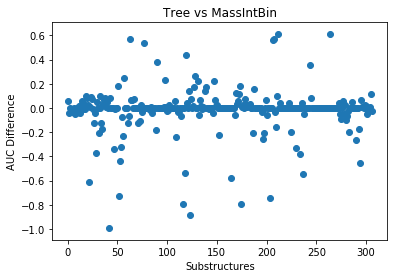

Improved: 89
Stayed same: 140
Worsen: 78


In [24]:
base_aucs = [auc[1] for auc in base_stats]
exp_aucs = [auc[1] for auc in exp_stats]
better, same, worse = compare_aucs(base_aucs, exp_aucs)
print("Improved: {}".format(len(better)))
print("Stayed same: {}".format(len(same)))
print("Worsen: {}".format(len(worse)))